In [186]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [188]:
len(words)

32033

(array([6.4000e+02, 2.9830e+03, 7.1330e+03, 1.6476e+04, 3.1080e+03,
        1.1180e+03, 5.0800e+02, 2.9000e+01, 3.0000e+01, 8.0000e+00]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <BarContainer object of 10 artists>)

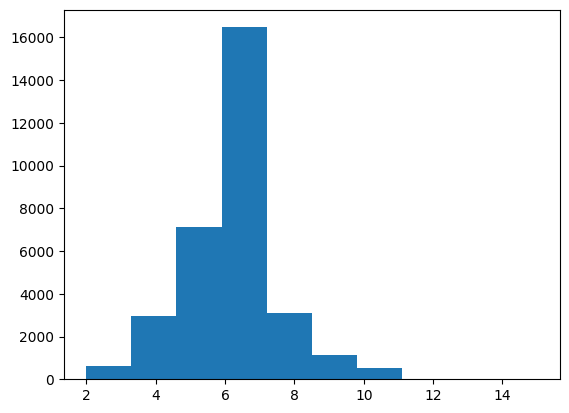

In [189]:
plt.hist([len(w) for w in words])

In [190]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [191]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [225]:
embedding_size = 10
hl_size = 400

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size),                       generator=g)
W1 = torch.randn((embedding_size * block_size, hl_size),    generator=g) * 0.2
b1 = torch.randn(hl_size,                                   generator=g) * 0.01
W2 = torch.randn((hl_size, 27),                             generator=g) * 0.01
b2 = torch.randn(27,                                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [226]:
@torch.no_grad()
def split_loss(split, verbose=True):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y)
    if verbose:
        print(split, loss.item())
    return loss.item()

In [227]:
max_steps = 400000

for i in range(max_steps):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (64,), generator=g)

    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    embcat = emb.view(-1, embedding_size * block_size)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i <= 200000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} (train), {split_loss('val', verbose=False):.4f} (val)')

# print(loss.item())

      0/ 400000: 3.3061 (train), 3.1953 (val)
  10000/ 400000: 2.1307 (train), 2.2275 (val)
  20000/ 400000: 1.9449 (train), 2.1821 (val)
  30000/ 400000: 2.0275 (train), 2.1720 (val)
  40000/ 400000: 2.0087 (train), 2.1778 (val)
  50000/ 400000: 1.6486 (train), 2.1683 (val)
  60000/ 400000: 2.1638 (train), 2.1677 (val)
  70000/ 400000: 2.1604 (train), 2.1601 (val)
  80000/ 400000: 2.0086 (train), 2.1596 (val)
  90000/ 400000: 1.8728 (train), 2.1599 (val)
 100000/ 400000: 1.8577 (train), 2.1696 (val)
 110000/ 400000: 2.1746 (train), 2.1810 (val)
 120000/ 400000: 2.0567 (train), 2.1741 (val)
 130000/ 400000: 1.8996 (train), 2.1651 (val)
 140000/ 400000: 1.9814 (train), 2.1808 (val)
 150000/ 400000: 2.1471 (train), 2.1673 (val)
 160000/ 400000: 1.9888 (train), 2.1782 (val)
 170000/ 400000: 2.3825 (train), 2.1745 (val)
 180000/ 400000: 2.4893 (train), 2.1581 (val)
 190000/ 400000: 2.0564 (train), 2.1637 (val)
 200000/ 400000: 2.1761 (train), 2.1718 (val)
 210000/ 400000: 1.7684 (train), 2

In [229]:
split_loss('train')
split_loss('val')

train 1.9530006647109985
val 2.096299409866333


2.096299409866333

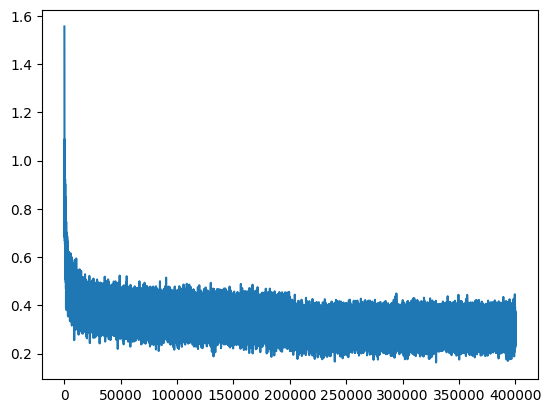

In [184]:
plt.plot(stepi, lossi)
# plt.plot(lri, lossi)

In [185]:
g = torch.Generator().manual_seed(4)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

bran.
jah.
lamyre.
aaraeh.
cae.
naiseylonne.
bluel.
peniyanna.
olo.
rem.
nica.
asaela.
humzhangeleigh.
lacquezeki.
kora.
joselea.
brys.
fes.
pheom.
shan.
